# Проект по созданию модели классификации токсичного текста

В данном проекте с использованием данных 160 000 заранее размеченных комментариев мы подготовим модель, которая позволит классифицировать комментарии пользователей "Викишоп" как токсичные. Предполагается, что на основе этого инструмента, токсичные комментарии будут отправляться на модерацию.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymystem3 import Mystem
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from sklearn.utils import shuffle
import re
import nltk
from textblob import TextBlob, Word
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/semionkaminsky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/semionkaminsky/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/semionkaminsky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Загрузка и осмотр данных

In [11]:
try:
    initial_df = pd.read_csv('toxic_comments.csv')
except:
    initial_df = pd.read_csv('/datasets/toxic_comments.csv')

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0



Частота классов


0    143346
1     16225
Name: toxic, dtype: int64

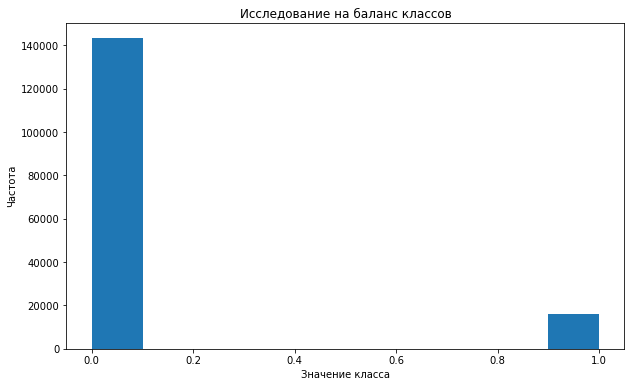

In [12]:
display(initial_df.head(20))
print()
print('Частота классов')
display(initial_df['toxic'].value_counts())

plt.figure(figsize = (10, 6))
plt.hist(initial_df['toxic'])
plt.title('Исследование на баланс классов')
plt.xlabel('Значение класса')
plt.ylabel('Частота')
plt.show()

### Комментарий
Да уж, некоторые токсичные комментарии сразу бросаются в глаза...

Также, видим значимый дисбаланс классов: токсичные составляют порядка 10% выборки. Обратим на это внимание при подготовке данных.

## Подготовка признаков
1. [x] Апсемплинг негативных комментариев в 8 раз
2. [x] Лемматизация, очистка, разделение выборки и создание признаков векторов TfIdf


In [13]:
# выполним лемматизацию
class Lemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, data):
        return self
    def lemmatize(self, row):
        sentence = row
        sent = TextBlob(sentence)
        return ' '. join([w.lemmatize() for w in sent.words])
    def transform(self, data):
        return data.apply(self.lemmatize)

# очистим от знаков и лишних пробелов
class Clearer(BaseEstimator, TransformerMixin):
    def __init__(self, sub = r'A-Za-z'):
        self.sub = sub
        return None
    def fit(self, data):
        return self
    def clear(self, row):
        cleared = re.sub(self.sub, ' ', row).split()
        return ' '.join(cleared)
    def transform(self, data):
        return data.apply(self.clear)
    
# поделим выборку, не забудем сохранить индексы тестовой и обучающей выборок    
class Splitter(BaseEstimator, TransformerMixin):
    def __init__(self, test_size):
        self.test_size = test_size
        return None
    def fit(self, data):
        return self
    def transform(self, data):
        train, test = train_test_split(data, random_state = 42, test_size = self.test_size)
        return [train, test, train.index, test.index]
    
class Upsampler(BaseEstimator, TransformerMixin):
    def __init__(self, target, repeat):
        self.target = target
        self.repeat = repeat
        return None
    def fit(self, train_test_list):
        return self
    def upsample(self, features, target, repeat):
        features_zeros = features[target == 0]
        features_ones = features[target == 1]
        target_zeros = target[target == 0]
        target_ones = target[target == 1]

        features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
        target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
        features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state = 42)
    
        return features_upsampled, target_upsampled

    def transform(self, train_test_list):
        features_train = train_test_list[0]
        target_train = self.target.iloc[train_test_list[2]]
        features_train, target_train = self.upsample(features_train, target_train, self.repeat)
        features_test, target_test = train_test_list[1], self.target.iloc[train_test_list[3]]
        return [features_train.reset_index(drop = True), features_test.reset_index(drop = True), target_train.reset_index(drop = True), target_test.reset_index(drop = True)]
        
    
# переведем строки в векторы с помощью TfIdf
class TfIdf(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, train_test_list):
        return self
    def transform(self, train_test_list):
        tf_idf = TfidfVectorizer(stop_words = stopwords)
        tf_idf.fit(train_test_list[0])
        features_train = tf_idf.transform(train_test_list[0])
        features_test = tf_idf.transform(train_test_list[1])
        target_train = train_test_list[2]
        target_test = train_test_list[3]
        return[features_train, features_test, target_train, target_test]
        

In [14]:
pipeline = Pipeline([
    ('lemm', Lemmatizer()),
    ('clear', Clearer()),
    ('splitter', Splitter(test_size = 0.2)),
    ('upsampler', Upsampler(initial_df['toxic'], 8)),
    ('tfidf', TfIdf())
])

In [15]:
features_train, features_test, target_train, target_test = pipeline.fit_transform(initial_df['text'])

### Комментарий
Итак, мы подготовили признаки. Посмотрим на получившийся баланс классов и пойдем дальше.

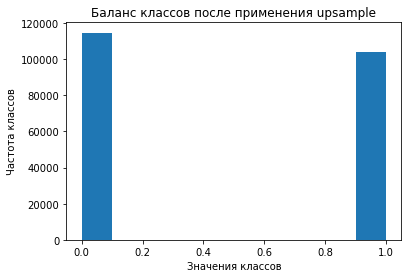

Частота классов


0    114675
1    103848
Name: toxic, dtype: int64

In [16]:
plt.figure()
plt.title('Баланс классов после применения upsample')
plt.xlabel('Значения классов')
plt.ylabel('Частота классов')
plt.hist(target_train)
plt.show()

print('Частота классов')
display(pd.Series(target_train).value_counts())

### Комментарий
Вот оно равенство!

Перехордим к обучению.

## Обучение моделей

In [17]:
#назначим scorer
my_scorer = make_scorer(f1_score, greater_is_better = True)
#создаем пустые модели
lreg = LogisticRegression(random_state = 42, n_jobs = -1)
tree = DecisionTreeClassifier(random_state = 42)
forest = RandomForestClassifier(random_state = 42)
sgb = LGBMClassifier(random_state = 42, n_jobs = -1, silent = True)

#формируем сетки гиперпараметров
lreg_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
            'max_iter': range(10, 200, 20), 'penalty': ['l1', 'l2', 'elasticnet', 'none']}
tree_grid = {'max_depth': range(1, 50)}
forest_grid = {'max_depth': range(1, 30), 'n_estimators': range(1, 150, 10)}
sgb_grid = {'n_estimators': range(1, 200, 10), 'max_depth': range(1, 50), 
            'learning_rate': [0, 0.1, 0.2, 0.3, 0.4, 0.5], 'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5], 
            'num_leaves': range(0, 50, 10)}

#готовим классы для обучения
best_tree = RandomizedSearchCV(tree, n_jobs = -1, n_iter = 9, 
                               param_distributions = tree_grid, random_state = 42, 
                               scoring = my_scorer, cv = 5)
best_forest = RandomizedSearchCV(forest, n_jobs = -1, n_iter = 3, 
                               param_distributions = forest_grid, random_state = 42, 
                               scoring = my_scorer, cv = 2)
best_sgb  = RandomizedSearchCV(sgb, n_jobs = -1, n_iter = 9, 
                               param_distributions = sgb_grid, random_state = 42, 
                               scoring = my_scorer, cv = 5)
best_lreg = RandomizedSearchCV(lreg, n_jobs = -1, n_iter = 9,
                              param_distributions = lreg_grid, cv = 5)

In [18]:
import time
#ФУНКЦИЯ ДЛЯ АВТОМАТИЗАЦИИ ОБУЧЕНИЯ, ЗАПОМИНАНИЯ МОДЕЛЕЙ И ВЫВОДА ПАРАМЕТРОВ ОБУЧЕНИЯ
def learner(estimator, 
            name, features_train = features_train, 
            target_train = target_train, 
            features_test = features_test,
            target_test = target_test):
    model_start = time.time()
    estimator.fit(features_train, target_train)

    model_end = time.time()
    test_predictions = estimator.predict(features_test)
    predict_end = time.time()
    learning_time = model_end - model_start
    predict_time = predict_end - model_end
    f1 = f1_score(target_test, test_predictions)
    try:
        params = estimator.best_params_
        print('Подобранные гиперпараметры:', params)
        print('Оценка модели', name,' f1_score =', f1)
        print('Время, потраченное на обучение модели:', learning_time, 'сек.')
        print('Время, потраченное на инференс:', predict_time)
        print()
        return pd.Series([estimator, f1_score, params , learning_time, predict_time],
                         index = ['Модель', 'Гиперпараметры', 'f1_score', 'Время обучения', 'Время инференса'])
    except:
        params = estimator.get_params()
        print('Подобранные гиперпараметры:', params)
        print('Оценка модели', name,' f1_score =', f1)
        print('Время, потраченное на обучение модели:', learning_time, 'сек.')
        print('Время, потраченное на инференс:', predict_time)
        print()
        return pd.Series([estimator, f1_score, params , learning_time, predict_time], index = ['Модель', 'Гиперпараметры', 'f1_score', 'Время обучения', 'Время инференса'])

In [19]:
models = pd.Series([best_lreg, best_tree, best_forest, best_sgb], 
                   index = ['Линейная регрессия', 'Решающее дерево', 'Случайный лес', 'Градиентный бустинг'])
result_1 = pd.DataFrame(columns = ['Модель','Гиперпараметры' , 'f1_score', 'Время обучения', 'Время инференса'])
for idx in ['Линейная регрессия', 'Решающее дерево', 'Случайный лес', 'Градиентный бустинг']:
    result_1 = result_1.append(learner(models[idx], idx), ignore_index = True)

/Users/semionkaminsky/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.95745986        nan 0.9574919         nan 0.95745986        nan
        nan 0.9574919  0.9574919 ]
  category=UserWarning
/Users/semionkaminsky/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Подобранные гиперпараметры: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 130}
Оценка модели Линейная регрессия  f1_score = 0.7510783358842353
Время, потраченное на обучение модели: 17.14446496963501 сек.
Время, потраченное на инференс: 0.016049861907958984

Подобранные гиперпараметры: {'max_depth': 48}
Оценка модели Решающее дерево  f1_score = 0.6274984857662024
Время, потраченное на обучение модели: 412.5091381072998 сек.
Время, потраченное на инференс: 0.03431892395019531

Подобранные гиперпараметры: {'n_estimators': 31, 'max_depth': 24}
Оценка модели Случайный лес  f1_score = 0.5284390758766272
Время, потраченное на обучение модели: 20.700566053390503 сек.
Время, потраченное на инференс: 0.13332700729370117

Подобранные гиперпараметры: {'reg_alpha': 0.3, 'num_leaves': 40, 'n_estimators': 171, 'max_depth': 33, 'learning_rate': 0.4}
Оценка модели Градиентный бустинг  f1_score = 0.7688014101057579
Время, потраченное на обучение модели: 868.7046370506287 сек.
Время, потраченное 

### Комментарий
Ура! Мы преодолели порог в 0.75. Осталось совсем немного: проверим на адекватность, поставивив в предсказание массив нулей (мы же помним из анализа баланса классов, что чаще всего текст нетоксичный).

In [20]:
constant_predict = np.zeros(features_test.shape[0])
print('f1 константной модели равен', f1_score(target_test, constant_predict))

f1 константной модели равен 0.0


## Заключение
Проверка на адекватность пройдена (на самом деле, именно из-за специфики f1 получаеься нулевой скор, так что проверка весьма условная)! Модель логистической регрессии прошла все проверки и признается лучшей моделью в данном проекте! Отлично, фиксируем: f1 = 0.763, время на обучение = 5 минут 30 секунд, время на предсказание = 0.003 секунды. Надо сказать, градиентный бустинг тоже прошел все проверки, но качество у него лучше всего на 5 тысячных, а время обучения больше в 2 с лишним раза. В общем, записываем в best_model логистическую регрессию.

In [21]:
best_model = best_lreg